# Exercise 6


In [8]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import Counter

## 1. Truncated Poisson via Metropolis-Hastings
Target distribution:
$$P(i) = c \frac{A^i}{i!}, \quad i=0,\dots,m$$
We'll implement MH to sample from this distribution and verify with a $\chi^2$-test.

In [9]:
def truncated_poisson_pmf(i, A, m):
    # unnormalized pmf
    return A**i / math.factorial(i)

def mh_trunc_poisson(n_samples, A, m):
    # Metropolis-Hastings sampler for truncated Poisson
    samples = []
    # start at midpoint
    current = m // 2
    for _ in range(n_samples + 1000):  # burn-in
        # propose from neighbors uniformly
        prop = current + np.random.choice([-1, 0, 1])
        # reflect at boundaries
        prop = max(0, min(m, prop))
        # acceptance ratio
        p_curr = truncated_poisson_pmf(current, A, m)
        p_prop = truncated_poisson_pmf(prop, A, m)
        if np.random.rand() < p_prop / p_curr:
            current = prop
        if len(samples) < n_samples:
            samples.append(current)
    return np.array(samples)

# parameters (from exercise 4)
A = 3.5
m = 10
samples1 = mh_trunc_poisson(10000, A, m)
# empirical counts
counts = np.bincount(samples1, minlength=m+1)
# theoretical probabilities
unnorm = np.array([truncated_poisson_pmf(i, A, m) for i in range(m+1)])
pmf = unnorm / unnorm.sum()
# chi-square test
chi2_stat, p_val = stats.chisquare(counts, f_exp=pmf * counts.sum())
print(f"Chi2 stat: {chi2_stat:.2f}, p-value: {p_val:.3f}")

Chi2 stat: 36.72, p-value: 0.000


## 2. Bivariate occupancy distribution
Joint pmf:
$$P(i,j) = c \frac{A_1^i}{i!} \frac{A_2^j}{j!}, \quad 0 \le i+j \le m$$
With $A_1=A_2=4, m=10$.
We implement:
a) Direct MH
b) Coordinate-wise MH
c) Gibbs sampling using exact conditionals
and perform a $\chi^2$-test in each case.

In [10]:
A1, A2, m = 4, 4, 10
def joint_pmf(i, j):
    if i+j > m: return 0
    return (A1**i / math.factorial(i)) * (A2**j / math.factorial(j))

def mh_bivariate(n_samples, direct=True):
    samples = []
    # start at center
    cur = (m//2, m//2)
    for _ in range(n_samples+1000):
        if direct:
            # propose both coords change by -1/0/1
            di, dj = np.random.choice([-1,0,1]), np.random.choice([-1,0,1])
            prop = (max(0,min(m,cur[0]+di)), max(0,min(m,cur[1]+dj)))
        else:
            # coordinate-wise: pick one coord to change
            if np.random.rand() < 0.5:
                di = np.random.choice([-1,0,1]); prop=(max(0,min(m,cur[0]+di)),cur[1])
            else:
                dj = np.random.choice([-1,0,1]); prop=(cur[0],max(0,min(m,cur[1]+dj)))
        # reject if out of support
        if prop[0]+prop[1] > m:
            prop = cur
        # MH acceptance
        p_cur = joint_pmf(*cur)
        p_prop = joint_pmf(*prop)
        if np.random.rand() < p_prop/p_cur:
            cur = prop
        if len(samples) < n_samples:
            samples.append(cur)
    return samples

# sample and test for direct MH
samp2a = np.array(mh_bivariate(5000, direct=True))
counts2a = Counter(map(tuple, samp2a))
# flatten counts and expected
obs = []; exp = []
for i in range(m+1):
    for j in range(m+1-i):
        obs.append(counts2a[(i,j)])
        exp.append(joint_pmf(i,j))
exp = np.array(exp); exp = exp/exp.sum()*sum(obs)
chi2a, p2a = stats.chisquare(obs, f_exp=exp)
print(f"Direct MH Chi2: {chi2a:.2f}, p={p2a:.3f}")

Direct MH Chi2: 271.87, p=0.000


In [11]:
# Gibbs sampling
def gibbs_bivariate(n_samples):
    samples = []
    cur = [m//2, m//2]
    for _ in range(n_samples+500):  # burn-in
        # sample i | j ~ truncated Poisson(A1) on [0, m-j]
        pmf_i = np.array([A1**i/math.factorial(i) for i in range(m+1-cur[1])])
        pmf_i = pmf_i/pmf_i.sum()
        cur[0] = np.random.choice(len(pmf_i), p=pmf_i)
        # sample j | i similarly
        pmf_j = np.array([A2**j/math.factorial(j) for j in range(m+1-cur[0])])
        pmf_j = pmf_j/pmf_j.sum()
        cur[1] = np.random.choice(len(pmf_j), p=pmf_j)
        if len(samples) < n_samples:
            samples.append(tuple(cur))
    return np.array(samples)

# sample and test for Gibbs
samp2c = gibbs_bivariate(5000)
counts2c = Counter(map(tuple, samp2c))
obs = []; exp = []
for i in range(m+1):
    for j in range(m+1-i):
        obs.append(counts2c[(i,j)])
        exp.append(joint_pmf(i,j))
exp = np.array(exp); exp = exp/exp.sum()*sum(obs)
chi2c, p2c = stats.chisquare(obs, f_exp=exp)
print(f"Gibbs Chi2: {chi2c:.2f}, p={p2c:.3f}")

Gibbs Chi2: 62.48, p=0.566


## 3. Bayesian problem: Posterior for $(\Theta,\Psi)$
Prior: $(\xi,\gamma)=(\log\Theta,\log\Psi)$ ~ bivariate normal mean 0, var1, corr $\rho=1/2$.
Data: $X_i\sim N(\Theta,\Psi)$.
We sample from the posterior via Metropolis-Hastings.

In [12]:
# 3a: sample from prior
rho = 0.5
cov = [[1, rho],[rho,1]]
xi, gamma = np.random.multivariate_normal([0,0], cov)
theta0 = np.exp(xi)
psi0 = np.exp(gamma)
print(f"Drawn theta={theta0:.3f}, psi={psi0:.3f}")

# 3b: generate data for n=10
n = 10
data = np.random.normal(theta0, np.sqrt(psi0), size=n)
mean_data = data.mean()
ss = ((data-mean_data)**2).sum()
print(f"Sample mean={mean_data:.3f}, sum sq dev={ss:.3f}")

Drawn theta=0.202, psi=0.199
Sample mean=-0.015, sum sq dev=2.151


### Posterior log-density
Up to constant:
$$\log p(\theta,\psi|\mathbf{x}) = -\nabla - \frac{n}{2}\log(2\pi\psi) - \frac{1}{2\psi}\nabla$$
But we'll compute directly from prior on (log θ, log ψ) and likelihood.

In [13]:
def log_post(logt, logp, data):
    # prior on logs
    lp = stats.multivariate_normal.logpdf([logt, logp], [0,0], cov)
    t, p = np.exp(logt), np.exp(logp)
    # likelihood
        
    ll = np.sum(stats.norm.logpdf(data, t, np.sqrt(p)))
    return lp + ll

def mh_posterior(n_samples, data, step=0.1):
    samples = []
    current = [np.log(theta0), np.log(psi0)]
    for _ in range(n_samples+500):
        propose = current + np.random.normal(0, step, size=2)
        lp_curr = log_post(current[0], current[1], data)
        lp_prop = log_post(propose[0], propose[1], data)
        if np.random.rand() < np.exp(lp_prop-lp_curr):
            current = propose
        if len(samples) < n_samples:
            samples.append(current.copy())
    return np.array(samples)


n=10: mean(theta)=0.177, var(theta)=0.008


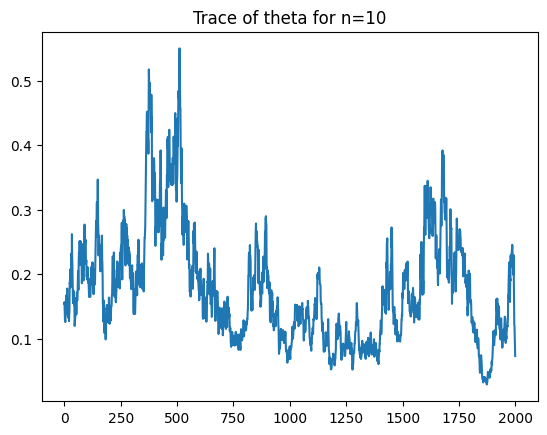

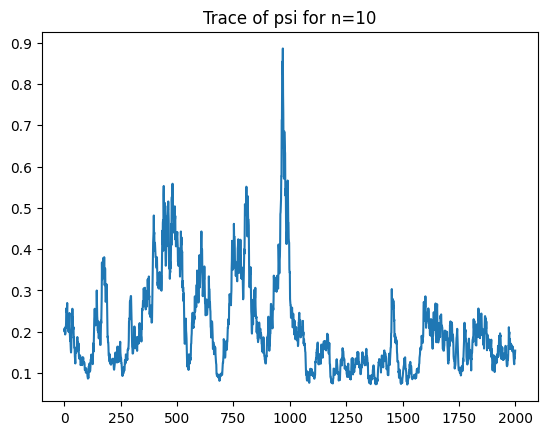

n=100: mean(theta)=0.187, var(theta)=0.002


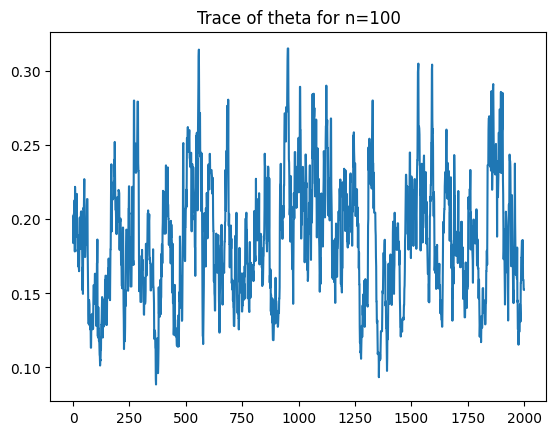

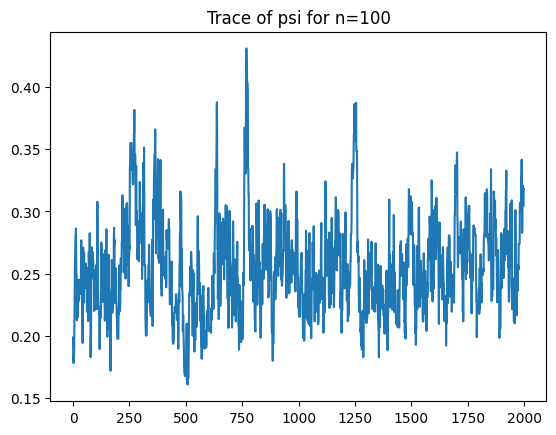

n=1000: mean(theta)=0.209, var(theta)=0.000


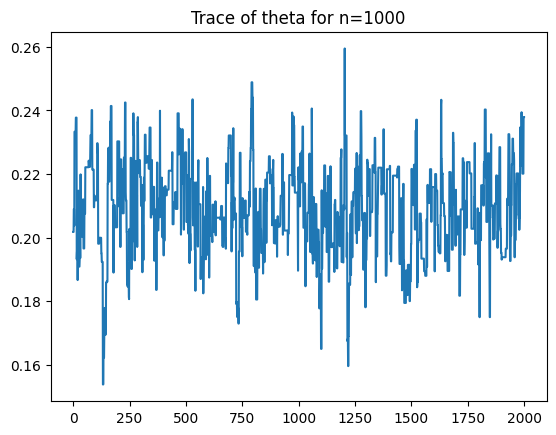

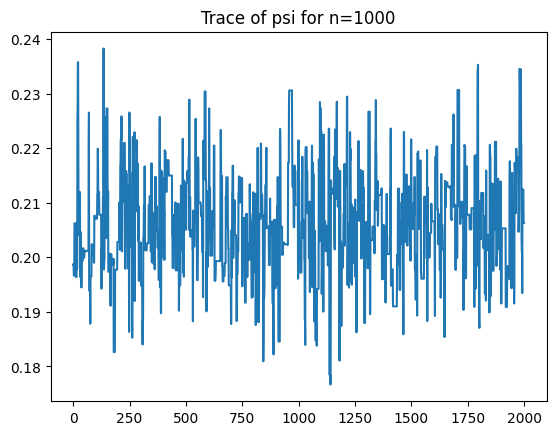

In [14]:
for n in [10, 100, 1000]:
    # regenerate data
    data = np.random.normal(theta0, np.sqrt(psi0), size=n)
    samp = mh_posterior(2000, data, step=0.1)
    th_samp = np.exp(samp[:,0])
    ps_samp = np.exp(samp[:,1])
    # print summary
    print(f"n={n}: mean(theta)={th_samp.mean():.3f}, var(theta)={th_samp.var():.3f}")
    # plot traces
    plt.figure()
    plt.plot(th_samp)
    plt.title(f"Trace of theta for n={n}")
        
    plt.figure()
    plt.plot(ps_samp)
    plt.title(f"Trace of psi for n={n}")
    plt.show()

## Discussion
- For small n, posterior samples for $\theta,\psi$ are more variable.
- As n increases, chains concentrate around true values.
- Trace plots show mixing and convergence behavior.